In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import rasterio

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from Water_Blance_Model import mYWBMnlS_RE, abcdnlS_RE, DWBMnlS_RE, GmYWBM_RE
from Rewrite_Func import nash_sutcliffe_efficiency, relative_error, kling_gupta_efficiency
from numba import njit, float64
from numba.experimental import jitclass
from netCDF4 import Dataset
from tqdm.notebook import trange

In [6]:
# 读取流域信息
basin_info      = pd.read_excel('../../Data/Basin_Selection/All_Selected_Basins.xlsx')
basin_list      = basin_info['stat_num'].astype(str)
cali_start_list = basin_info['cali_start']
cali_end_list   = basin_info['cali_end']
vali_start_list = basin_info['vali_start']
vali_end_list   = basin_info['vali_end']

# 集总式模型数据读取
def get_data_lumped(basin, basin_idx):
    filepath = f"../../../2025_03_Hydrological_Models/Data/New_Hydro_Climatic/NHC_{basin}.txt"
    hc_data = pd.read_csv(filepath, sep = '\t', header=0, index_col='Time', parse_dates=['Time'])
    cali_start = pd.to_datetime(f"{str(cali_start_list[basin_idx])}-01-01")
    cali_end   = pd.to_datetime(f"{str(cali_end_list[basin_idx])}-12-31")
    vali_start = pd.to_datetime(f"{str(vali_start_list[basin_idx])}-01-01")
    vali_end   = pd.to_datetime(f"{str(vali_end_list[basin_idx])}-12-31")
    esim_start = pd.Timestamp('1980-01-01')
    esim_end   = pd.Timestamp('2022-12-31')

    cali_data = hc_data.loc[cali_start : cali_end]
    vali_data = hc_data.loc[vali_start : vali_end]
    esim_data = hc_data.loc[esim_start : esim_end]

    x_cali = cali_data[['PRE_CRU', 'TMP_CRU', 'PET_CRU']].values
    y_cali = cali_data['RUN'].values
    x_vali = vali_data[['PRE_CRU', 'TMP_CRU', 'PET_CRU']].values
    y_vali = vali_data['RUN'].values
    x_esim = esim_data[['PRE_CRU', 'TMP_CRU', 'PET_CRU']].values

    ae_filepath = f"../../../2025_03_Hydrological_Models/Data/AE/AE_{basin}.txt"
    ae_obs = pd.read_csv(ae_filepath, sep = '\t', header=0, index_col='Time', parse_dates=['Time'])

    y_esim = ae_obs['AE'].values
    return x_cali, y_cali, x_vali, y_vali, x_esim, y_esim

def read_georaster(filepath):
    with rasterio.open(filepath) as src:
        temp_data = src.read(1)
        new_data = temp_data.copy().astype(np.float64)
        new_data[new_data < 0] = np.nan
        # 获取经纬度范围
        bounds = src.bounds
        # 获取分辨率
        res = src.res
        # 生成经纬度坐标
        lon = np.round(np.arange(bounds.left + res[0] / 2, bounds.right, res[0]), 3)
        lat = np.round(np.arange(bounds.top - res[1] / 2, bounds.bottom, -res[1]), 3)
    return new_data, lon, lat, bounds, res[0]

def read_nc(filepath, varname):
    cf_info = Dataset(filepath)
    cf_data = np.rot90(np.flip(cf_info.variables[varname][:].data, axis=1), k = -1, axes=(1 ,2))
    cf_lon = cf_info.variables['lon'][:].data
    cf_lat = cf_info.variables['lat'][:].data
    cf_info.close()
    return cf_data, cf_lon, cf_lat

spec = [
    ('PRE',      float64[:, :, :]),
    ('TMP',      float64[:, :, :]),
    ('PET',      float64[:, :, :]),
    ('TI',       float64[:, :]),
    ('ST',       float64[:, :]),
    ('STP',      float64[:, :]),
    ('mask',     float64[:, :]),
    ('mask_res', float64),
    ('mask_lon', float64[:]),
    ('mask_lat', float64[:]),
    ('TI_lon',   float64[:]),
    ('TI_lat',   float64[:]),
]
STP = pd.read_excel("../../../2025_03_Hydrological_Models/Raw_Data/D_TEXTURE_USDA.xlsx")
STP = STP[['CODE', 's', 'fc', 'wp']].to_numpy()
@jitclass(spec)
class inputData:
    def __init__(self, PRE, TMP, PET, TI, ST, STP, mask, mask_res, mask_lon, mask_lat, TI_lon, TI_lat):
        self.PRE        = PRE
        self.TMP        = TMP
        self.PET        = PET
        self.TI         = TI
        self.ST         = ST
        self.STP        = STP
        self.mask       = mask
        self.mask_res   = mask_res
        self.mask_lon   = mask_lon
        self.mask_lat   = mask_lat
        self.TI_lon     = TI_lon
        self.TI_lat     = TI_lat
def get_data_distributed(basin, b):
    filepath    = f"../../../2025_03_Hydrological_Models/Data/New_Hydro_Climatic/NHC_{basin}.txt"
    # time for calibration and validation
    hc_data     = pd.read_csv(filepath, sep='\t', header=0, index_col='Time', parse_dates=['Time'])
    cali_start  = pd.to_datetime(f"{str(cali_start_list[b])}-01-01")
    cali_end    = pd.to_datetime(f"{str(cali_end_list[b])}-12-31")
    vali_start  = pd.to_datetime(f"{str(vali_start_list[b])}-01-01")
    vali_end    = pd.to_datetime(f"{str(vali_end_list[b])}-12-31")
    esim_start  = pd.Timestamp('1980-01-01')
    esim_end    = pd.Timestamp('2022-12-31')
    # time index
    cali_loc    = (hc_data.index >= cali_start) & (hc_data.index <= cali_end)
    vali_loc    = (hc_data.index >= vali_start) & (hc_data.index <= vali_end)
    esim_loc    = (hc_data.index >= esim_start) & (hc_data.index <= esim_end)

    _, _, _, _, _, y_esim = get_data_lumped(basin, b)
    # runoff series
    y_cali = hc_data.loc[cali_start:cali_end]['RUN'].to_numpy()
    y_vali = hc_data.loc[vali_start:vali_end]['RUN'].to_numpy()
    # basin grid
    basin_mask, mask_lon, mask_lat, mask_bounds, mask_res = read_georaster(f"../../../2025_03_Hydrological_Models/Data/Basin_Boundary_TIF/{basin}.tif")
    basin_mask[basin_mask >= 0] = 1
    # ti
    TI, TI_lon, TI_lat, TI_bounds, TI_res = read_georaster(f"../../../2025_03_Hydrological_Models/Data/Underlying/TI/TI_{basin}.tif")
    # soil_texture
    ST, ST_lon, ST_lat, ST_bounds, ST_res = read_georaster(f"../../../2025_03_Hydrological_Models/Data/Underlying/Soil_Texture/Soil_Texture_{basin}.tif")
    # climatic forcing
    PRE, cf_lon, cf_lat = read_nc(f"../../../2025_03_Hydrological_Models/Data/CRU/PRE_CRU/PRE_{basin}.nc", 'PRE')
    TMP, _, _ = read_nc(f"../../../2025_03_Hydrological_Models/Data/CRU/TMP_CRU/TMP_{basin}.nc", 'TMP')
    PET, _, _ = read_nc(f"../../../2025_03_Hydrological_Models/Data/CRU/PET_CRU/PET_{basin}.nc", 'PET')

    PRE_cali = PRE[cali_loc, :, :]
    TMP_cali = TMP[cali_loc, :, :]
    PET_cali = PET[cali_loc, :, :] * 30.4
    PRE_vali = PRE[vali_loc, :, :]
    TMP_vali = TMP[vali_loc, :, :]
    PET_vali = PET[vali_loc, :, :] * 30.4
    PRE_esim = PRE[esim_loc, :, :]
    TMP_esim = TMP[esim_loc, :, :]
    PET_esim = PET[esim_loc, :, :] * 30.4

    x_cali = inputData(PRE_cali, TMP_cali, PET_cali, TI, ST, STP, basin_mask, mask_res, mask_lon, mask_lat, TI_lon, TI_lat)
    x_vali = inputData(PRE_vali, TMP_vali, PET_vali, TI, ST, STP, basin_mask, mask_res, mask_lon, mask_lat, TI_lon, TI_lat)
    x_esim = inputData(PRE_esim, TMP_esim, PET_esim, TI, ST, STP, basin_mask, mask_res, mask_lon, mask_lat, TI_lon, TI_lat)
    return x_cali, y_cali, x_vali, y_vali, x_esim, y_esim

In [ ]:
result_best_RE  = np.full(2003, np.nan)
result_best_KGE = np.full(2003, np.nan)
result_best_CF  = np.full(2003, np.nan)
params_best_RE  = np.full((2003, 5), np.nan)
params_best_KGE = np.full((2003, 5), np.nan)
params_best_CF  = np.full((2003, 5), np.nan)
kge_cali_results_df = pd.DataFrame(np.full((2003, 10), np.nan))
kge_vali_results_df = pd.DataFrame(np.full((2003, 10), np.nan))
kge_esim_results_df = pd.DataFrame(np.full((2003, 10), np.nan))
re_cali_results_df  = pd.DataFrame(np.full((2003, 10), np.nan))
re_vali_results_df  = pd.DataFrame(np.full((2003, 10), np.nan))
re_esim_results_df  = pd.DataFrame(np.full((2003, 10), np.nan))

hm_fn = mYWBMnlS_RE
model_name = 'mYWBM'

for loop in range(10):
    # print(f"Loop {loop+1}")
    params_filepath = f"../../../2025_03_Hydrological_Models/Results/Calibration/{model_name}/{model_name}_Calibration_Params_{loop+1}.txt"
    if not os.path.exists(params_filepath):
        continue
    all_params = pd.read_csv(params_filepath, sep = '\t', header=0, index_col=0)
    all_params['Ksn'] = all_params['Ksn'].fillna(0)
    all_params = all_params.values[:, :-1]+1e-5
    exec(f"all_params_{loop} = all_params")

for basin_idx in trange(len(basin_list), desc='Processing Basins'):
    basin = basin_list[basin_idx]
    x_cali, y_cali, x_vali, y_vali, x_esim, y_esim = get_data_lumped(basin, basin_idx)
    for loop in range(10):
        all_params = eval(f"all_params_{loop}")
        params = all_params[basin_idx]
        y_cali_pred, _ = hm_fn(x_cali, params)
        y_vali_pred, _ = hm_fn(x_vali, params)
        _, y_esim_pred = hm_fn(x_esim, params)

        RE_cali  = relative_error(y_cali, y_cali_pred) * 100
        KGE_cali = kling_gupta_efficiency(y_cali, y_cali_pred)

        RE_vali  = relative_error(y_vali, y_vali_pred) * 100
        KGE_vali = kling_gupta_efficiency(y_vali, y_vali_pred)

        RE_esim  = relative_error(y_esim, y_esim_pred) * 100
        KGE_esim = kling_gupta_efficiency(y_esim, y_esim_pred)

        CF  = KGE_cali + 5 * np.abs(RE_cali)

        if np.isnan(result_best_RE[basin_idx]) or (np.abs(RE_cali) < np.abs(result_best_RE[basin_idx])):
            result_best_RE[basin_idx]  = RE_cali
            params_best_RE[basin_idx]  = params
        if np.isnan(result_best_KGE[basin_idx]) or (KGE_cali > result_best_KGE[basin_idx]):
            result_best_KGE[basin_idx] = KGE_cali
            params_best_KGE[basin_idx] = params
        if np.isnan(result_best_CF[basin_idx]) or (CF > result_best_CF[basin_idx]):
            result_best_CF[basin_idx]  = CF
            params_best_CF[basin_idx]  = params

        kge_cali_results_df.iloc[basin_idx, loop]   = KGE_cali
        kge_vali_results_df.iloc[basin_idx, loop]   = KGE_vali
        kge_esim_results_df.iloc[basin_idx, loop]   = KGE_esim
        re_cali_results_df.iloc[basin_idx, loop]    = RE_cali
        re_vali_results_df.iloc[basin_idx, loop]    = RE_vali
        re_esim_results_df.iloc[basin_idx, loop]    = RE_esim

params_best_KGE_df = pd.DataFrame(params_best_KGE, columns=['a', 'b', 'c', 'd', 'Ksn'])
params_best_KGE_df.insert(0, 'stat_num', basin_list)
params_best_KGE_df.set_index('stat_num', inplace=True)
params_best_KGE_df.to_csv(f"../../Data/Params/01_{model_name}_Best_Params_KGE.txt", sep = '\t', index=True, float_format='%.4f')
print(params_best_KGE_df.min(), params_best_KGE_df.max())

params_best_RE_df = pd.DataFrame(params_best_RE, columns=['a', 'b', 'c', 'd', 'Ksn'])
params_best_RE_df.insert(0, 'stat_num', basin_list)
params_best_RE_df.set_index('stat_num', inplace=True)
params_best_RE_df.to_csv(f"../../Data/Params/02_{model_name}_Best_Params_RE.txt", sep = '\t', index=True, float_format='%.4f')
print(params_best_RE_df.min(), params_best_RE_df.max())

params_best_CF_df = pd.DataFrame(params_best_CF, columns=['a', 'b', 'c', 'd', 'Ksn'])
params_best_CF_df.insert(0, 'stat_num', basin_list)
params_best_CF_df.set_index('stat_num', inplace=True)
params_best_CF_df.to_csv(f"../../Data/Params/03_{model_name}_Best_Params_CF.txt", sep = '\t', index=True, float_format='%.4f')
print(params_best_CF_df.min(), params_best_CF_df.max())

fig, ax = plt.subplots(3, 2, figsize=(12, 10))
sns.boxplot(data=kge_cali_results_df, ax=ax[0, 0])
ax[0, 0].set_title('KGE Calibration Results')
ax[0, 0].set_ylim(-0.5, 1.0)
sns.boxplot(data=kge_vali_results_df, ax=ax[0, 1])
ax[0, 1].set_title('KGE Validation Results')
ax[0, 1].set_ylim(-0.5, 1.0)
sns.boxplot(data=re_cali_results_df, ax=ax[1, 0])
ax[1, 0].set_title('RE Calibration Results')
ax[1, 0].set_ylim(-40, 40)
sns.boxplot(data=re_vali_results_df, ax=ax[1, 1])
ax[1, 1].set_title('RE Validation Results')
ax[1, 1].set_ylim(-40, 40)
sns.boxplot(data=kge_esim_results_df, ax=ax[2, 0])
ax[2, 0].set_title('KGE Extended Simulation Results')
ax[2, 0].set_ylim(-0.5, 1.0)
sns.boxplot(data=re_esim_results_df, ax=ax[2, 1])
ax[2, 1].set_title('RE Extended Simulation Results')
ax[2, 1].set_ylim(-40, 40)
plt.tight_layout()

Processing Basins:   0%|          | 0/2003 [00:00<?, ?it/s]

a        0.00101
b        0.00101
c        0.05001
d      100.00001
Ksn      0.00001
dtype: float64 a         2.00001
b         0.65001
c         0.95001
d      2000.00001
Ksn       1.00001
dtype: float64
a        0.00101
b        0.00101
c        0.05001
d      100.00001
Ksn      0.00001
dtype: float64 a         2.00001
b         0.65001
c         0.95001
d      2000.00001
Ksn       1.00001
dtype: float64
a        0.00101
b        0.00101
c        0.05001
d      100.00001
Ksn      0.00001
dtype: float64 a         2.00001
b         0.65001
c         0.95001
d      2000.00001
Ksn       1.00001
dtype: float64


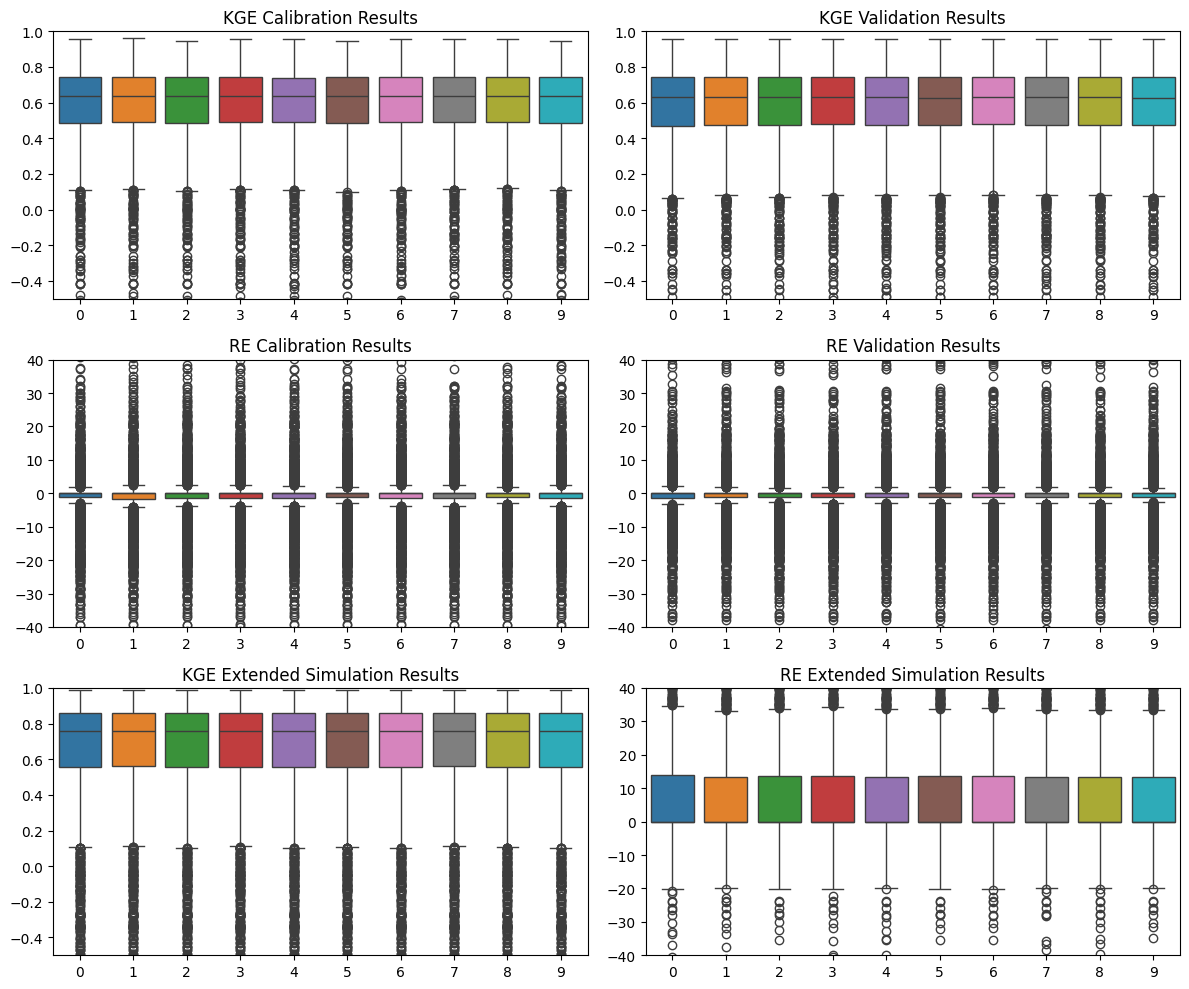

In [13]:
result_best_RE  = np.full(2003, np.nan)
result_best_KGE = np.full(2003, np.nan)
result_best_CF  = np.full(2003, np.nan)
params_best_RE  = np.full((2003, 5), np.nan)
params_best_KGE = np.full((2003, 5), np.nan)
params_best_CF  = np.full((2003, 5), np.nan)
kge_cali_results_df = pd.DataFrame(np.full((2003, 10), np.nan))
kge_vali_results_df = pd.DataFrame(np.full((2003, 10), np.nan))
kge_esim_results_df = pd.DataFrame(np.full((2003, 10), np.nan))
re_cali_results_df  = pd.DataFrame(np.full((2003, 10), np.nan))
re_vali_results_df  = pd.DataFrame(np.full((2003, 10), np.nan))
re_esim_results_df  = pd.DataFrame(np.full((2003, 10), np.nan))

hm_fn = GmYWBM_RE
model_name = 'GmYWBM'

for loop in range(10):
    # print(f"Loop {loop+1}")
    params_filepath = f"../../../2025_03_Hydrological_Models/Results/Calibration/{model_name}/{model_name}_Calibration_Params_{loop+1}.txt"
    if not os.path.exists(params_filepath):
        continue
    all_params = pd.read_csv(params_filepath, sep = '\t', header=0, index_col=0)
    all_params['Ksn'] = all_params['Ksn'].fillna(0)
    all_params = all_params.values[:, :-1]+1e-5
    exec(f"all_params_{loop} = all_params")

for basin_idx in trange(len(basin_list), desc='Processing Basins'):
    basin = basin_list[basin_idx]
    x_cali, y_cali, x_vali, y_vali, x_esim, y_esim = get_data_distributed(basin, basin_idx)
    for loop in range(10):
        all_params = eval(f"all_params_{loop}")
        params = all_params[basin_idx]
        y_cali_pred, _ = hm_fn(x_cali, params)
        y_vali_pred, _ = hm_fn(x_vali, params)
        _, y_esim_pred = hm_fn(x_esim, params)

        RE_cali  = relative_error(y_cali, y_cali_pred) * 100
        KGE_cali = kling_gupta_efficiency(y_cali, y_cali_pred)

        RE_vali  = relative_error(y_vali, y_vali_pred) * 100
        KGE_vali = kling_gupta_efficiency(y_vali, y_vali_pred)

        RE_esim  = relative_error(y_esim, y_esim_pred) * 100
        KGE_esim = kling_gupta_efficiency(y_esim, y_esim_pred)

        CF  = KGE_cali + 5 * np.abs(RE_cali)

        if np.isnan(result_best_RE[basin_idx]) or (np.abs(RE_cali) < np.abs(result_best_RE[basin_idx])):
            result_best_RE[basin_idx]  = RE_cali
            params_best_RE[basin_idx]  = params
        if np.isnan(result_best_KGE[basin_idx]) or (KGE_cali > result_best_KGE[basin_idx]):
            result_best_KGE[basin_idx] = KGE_cali
            params_best_KGE[basin_idx] = params
        if np.isnan(result_best_CF[basin_idx]) or (CF > result_best_CF[basin_idx]):
            result_best_CF[basin_idx]  = CF
            params_best_CF[basin_idx]  = params

        kge_cali_results_df.iloc[basin_idx, loop]   = KGE_cali
        kge_vali_results_df.iloc[basin_idx, loop]   = KGE_vali
        kge_esim_results_df.iloc[basin_idx, loop]   = KGE_esim
        re_cali_results_df.iloc[basin_idx, loop]    = RE_cali
        re_vali_results_df.iloc[basin_idx, loop]    = RE_vali
        re_esim_results_df.iloc[basin_idx, loop]    = RE_esim

params_best_KGE_df = pd.DataFrame(params_best_KGE, columns=['a', 'b', 'c', 'd', 'Ksn'])
params_best_KGE_df.insert(0, 'stat_num', basin_list)
params_best_KGE_df.set_index('stat_num', inplace=True)
params_best_KGE_df.to_csv(f"../../Data/Params/01_{model_name}_Best_Params_KGE.txt", sep = '\t', index=True, float_format='%.4f')
print(params_best_KGE_df.min(), params_best_KGE_df.max())

params_best_RE_df = pd.DataFrame(params_best_RE, columns=['a', 'b', 'c', 'd', 'Ksn'])
params_best_RE_df.insert(0, 'stat_num', basin_list)
params_best_RE_df.set_index('stat_num', inplace=True)
params_best_RE_df.to_csv(f"../../Data/Params/02_{model_name}_Best_Params_RE.txt", sep = '\t', index=True, float_format='%.4f')
print(params_best_RE_df.min(), params_best_RE_df.max())

params_best_CF_df = pd.DataFrame(params_best_CF, columns=['a', 'b', 'c', 'd', 'Ksn'])
params_best_CF_df.insert(0, 'stat_num', basin_list)
params_best_CF_df.set_index('stat_num', inplace=True)
params_best_CF_df.to_csv(f"../../Data/Params/03_{model_name}_Best_Params_CF.txt", sep = '\t', index=True, float_format='%.4f')
print(params_best_CF_df.min(), params_best_CF_df.max())

fig, ax = plt.subplots(3, 2, figsize=(12, 10))
sns.boxplot(data=kge_cali_results_df, ax=ax[0, 0])
ax[0, 0].set_title('KGE Calibration Results')
ax[0, 0].set_ylim(-0.5, 1.0)
sns.boxplot(data=kge_vali_results_df, ax=ax[0, 1])
ax[0, 1].set_title('KGE Validation Results')
ax[0, 1].set_ylim(-0.5, 1.0)
sns.boxplot(data=re_cali_results_df, ax=ax[1, 0])
ax[1, 0].set_title('RE Calibration Results')
ax[1, 0].set_ylim(-40, 40)
sns.boxplot(data=re_vali_results_df, ax=ax[1, 1])
ax[1, 1].set_title('RE Validation Results')
ax[1, 1].set_ylim(-40, 40)
sns.boxplot(data=kge_esim_results_df, ax=ax[2, 0])
ax[2, 0].set_title('KGE Extended Simulation Results')
ax[2, 0].set_ylim(-0.5, 1.0)
sns.boxplot(data=re_esim_results_df, ax=ax[2, 1])
ax[2, 1].set_title('RE Extended Simulation Results')
ax[2, 1].set_ylim(-40, 40)
plt.tight_layout()